## Aerial Images CNN Classifer using Transfer Learning on VGG16 CNN Architecture  

### importing all the necessary Libraries

In [16]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D , Activation , MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
import fnmatch
import os 
import cv2
import random
import matplotlib.image as mpimg

import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.engine import Model
from keras.applications import vgg16 as vgg
from keras.applications import  inception_v3, resnet50, mobilenet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.preprocessing import image

#ignore all Warnings
import warnings; warnings.simplefilter('ignore')

## Visulaizing dataset into 6 Classses :  Cemetery , Fields , Houses , Industry , River , Trees 

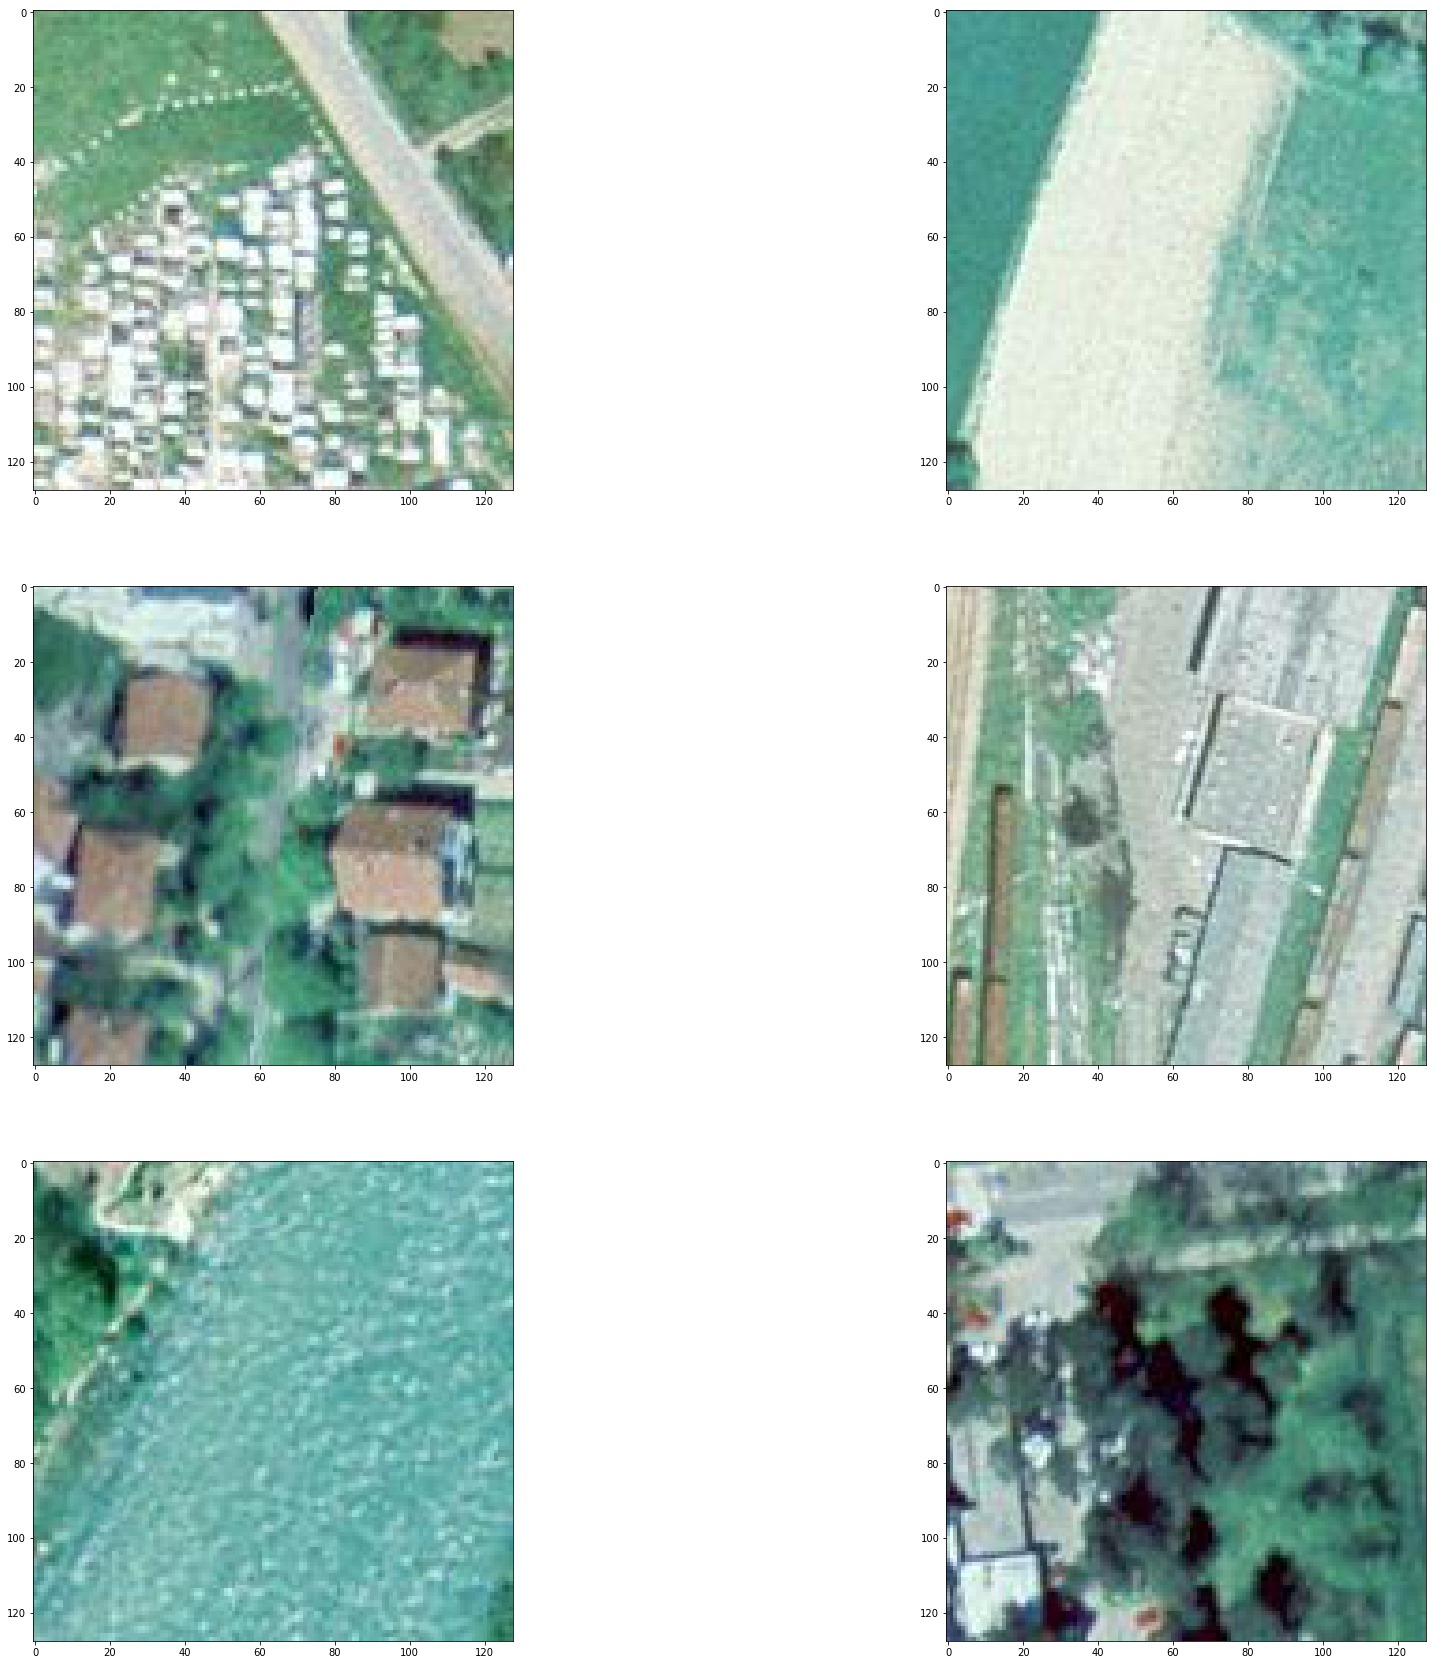

In [17]:

cemetery_dir = 'train/cemetery'
cemetery = ['train/cemetery/{}'.format(i) for i in os.listdir(cemetery_dir) if 'cemetery' in i] 

field_dir = 'train/field'
field = ['train/field/{}'.format(i) for i in os.listdir(field_dir) if 'field' in i]

houses_dir = 'train/houses'
houses = ['train/houses/{}'.format(i) for i in os.listdir(houses_dir) if 'houses' in i]

industry_dir = 'train/industry'
industry = ['train/industry/{}'.format(i) for i in os.listdir(industry_dir) if 'industry' in i]

river_dir = 'train/river'
river = ['train/river/{}'.format(i) for i in os.listdir(river_dir) if 'river' in i]

trees_dir = 'train/trees'
trees = ['train/trees/{}'.format(i) for i in os.listdir(trees_dir) if 'trees' in i]


all=[]
all.append(cemetery)
all.append(field)
all.append(houses)
all.append(industry)
all.append(river)
all.append(trees)


import matplotlib.image as mpimg
i=1
fig=plt.figure(figsize=(30,30))
for ima in all[0:6]:
    img=mpimg.imread(ima[0])
    plt.subplot(3,2,i)
    plt.imshow(img)
    i=i+1

## Statistical Analysis on individual Class images count 

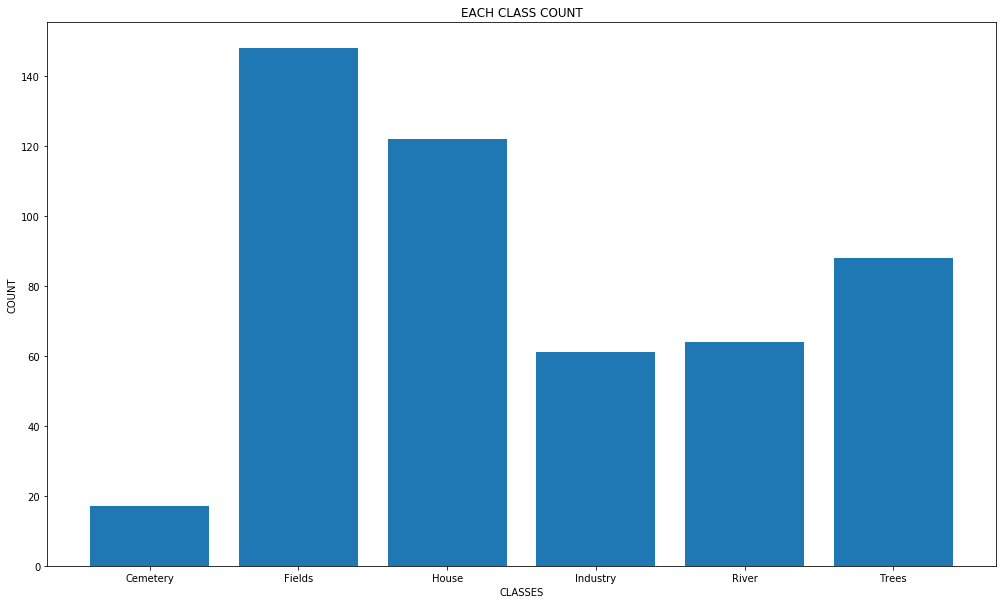

In [18]:

c_count=len(fnmatch.filter(os.listdir('train/cemetery/'), '*.jpg'))
f_count=len(fnmatch.filter(os.listdir('train/field/'), '*.jpg'))
h_count=len(fnmatch.filter(os.listdir('train/houses/'), '*.jpg'))
i_count=len(fnmatch.filter(os.listdir('train/industry/'), '*.jpg'))
r_count=len(fnmatch.filter(os.listdir('train/river/'), '*.jpg'))
t_count=len(fnmatch.filter(os.listdir('train/trees/'), '*.jpg'))

D = {'Cemetery':c_count, 'Fields':f_count, 'House':h_count, 'Industry':i_count, 'River':r_count , 'Trees':t_count}
fig=plt.figure(figsize=(17,10))
plt.bar(range(len(D)), list(D.values()), align='center' )
plt.xticks(range(len(D)), list(D.keys()))
plt.xlabel('CLASSES')
plt.ylabel('COUNT')
plt.title('EACH CLASS COUNT')

plt.show()

### Setting up parameters for Training 

In [41]:
img_width, img_height = 48, 48
train_data_dir = 'train'
validation_data_dir='validation'
test_data_dir='test'
batch_size = 32
epochs = 20

### Calling and Building  the VGG16 Model 

In [42]:
vgg_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

for layer in vgg_model.layers[:-2]:
    layer.trainable = False

 ## Displaying the trainable layers 
 ### Last 2 Layers are trainable  

In [43]:
for layer in vgg_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f136eed07f0> False
<keras.layers.convolutional.Conv2D object at 0x7f136eed0ef0> False
<keras.layers.convolutional.Conv2D object at 0x7f136eed0f28> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1334551780> False
<keras.layers.convolutional.Conv2D object at 0x7f136efdb6d8> False
<keras.layers.convolutional.Conv2D object at 0x7f133455ca58> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1334574d30> False
<keras.layers.convolutional.Conv2D object at 0x7f1334574fd0> False
<keras.layers.convolutional.Conv2D object at 0x7f13344db588> False
<keras.layers.convolutional.Conv2D object at 0x7f13344f5cf8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f13344a73c8> False
<keras.layers.convolutional.Conv2D object at 0x7f1334488b00> False
<keras.layers.convolutional.Conv2D object at 0x7f1334445278> False
<keras.layers.convolutional.Conv2D object at 0x7f1334458f28> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1334472f28>

## Building the exit and output layers 

In [44]:

# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 6150      
Total params: 15,246,150
Trainable params: 2,891,270
Non-trainable params: 12,354,880
_________________________________________________________________


## Data Augumentation

In [45]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

## Batchwise Training 

In [46]:
train_batchsize = 100
val_batchsize = 10


train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=train_batchsize,
        class_mode='categorical')

Found 500 images belonging to 6 classes.


In [47]:
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=train_batchsize,
        class_mode='categorical')

Found 44 images belonging to 6 classes.


In [48]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=val_batchsize,
        class_mode='categorical')

Found 64 images belonging to 6 classes.


## Training the Model 

In [49]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['acc'])


training = model.fit_generator(
      train_generator,
      steps_per_epoch=5,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=100,
      verbose=1)   

model.save('CNN_VGGNET.h5')

Epoch 1/100
5/5 [==============================] - 1s 293ms/step - loss: 1.7550 - acc: 0.2700 - val_loss: 1.3360 - val_acc: 0.7380
Epoch 2/100
5/5 [==============================] - 1s 176ms/step - loss: 1.2393 - acc: 0.5720 - val_loss: 1.0070 - val_acc: 0.7609
Epoch 3/100
5/5 [==============================] - 1s 176ms/step - loss: 0.9269 - acc: 0.7120 - val_loss: 0.7776 - val_acc: 0.8461
Epoch 4/100
5/5 [==============================] - 1s 176ms/step - loss: 0.7173 - acc: 0.7740 - val_loss: 0.6410 - val_acc: 0.7956
Epoch 5/100
5/5 [==============================] - 1s 177ms/step - loss: 0.6058 - acc: 0.7900 - val_loss: 0.4960 - val_acc: 0.8166
Epoch 6/100
5/5 [==============================] - 1s 181ms/step - loss: 0.5489 - acc: 0.8000 - val_loss: 0.3916 - val_acc: 0.8886
Epoch 7/100
5/5 [==============================] - 1s 176ms/step - loss: 0.4768 - acc: 0.8260 - val_loss: 0.3703 - val_acc: 0.8912
Epoch 8/100
5/5 [==============================] - 1s 180ms/step - loss: 0.4622 - a

## Ploting the Model Metrics 

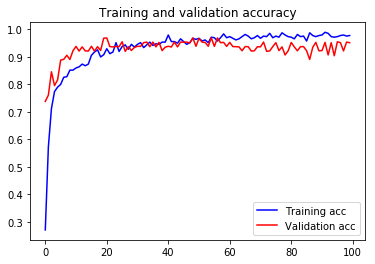

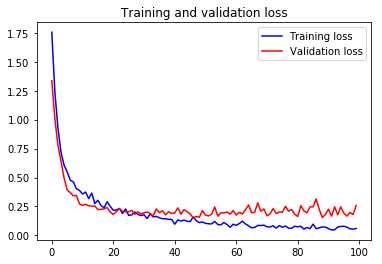

In [50]:
acc = training.history['acc']
val_acc = training.history['val_acc']
loss = training.history['loss']
val_loss = training.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## Testing the Mdoel 

In [51]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)
 
# Get the filenames from the generator
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))


Found 64 images belonging to 6 classes.
7/6 [================================] - 0s 28ms/step
No of errors = 3/64


In [52]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)


test_fnames = test_generator.filenames
test_ground_truth = validation_generator.classes
test_label2index = validation_generator.class_indices
test_idx2label = dict((v,k) for k,v in label2index.items())



Found 44 images belonging to 6 classes.


## TESTING  PREDICTIONS 

5/4 [==================================] - 0s 10ms/step
No of errors = 3/44


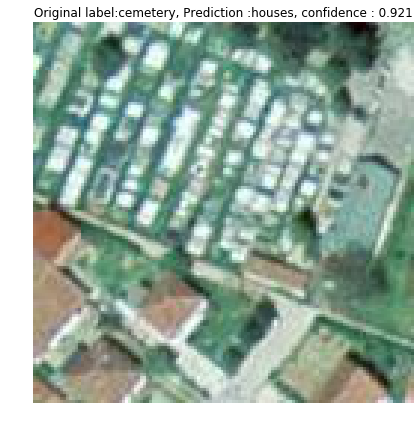

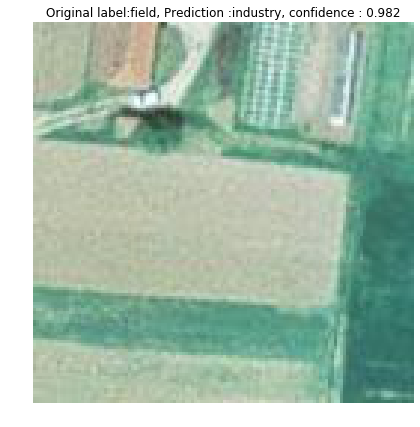

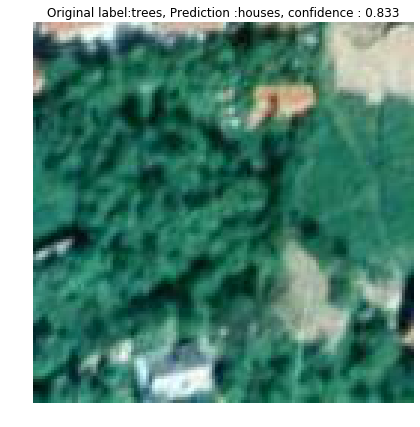

In [53]:
test_predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != test_ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = image.load_img('{}/{}'.format(validation_data_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)

## TESTING THE  DATASET  WITH A CLASSIC VANILLA CNN CUSTOM MODEL 

In [ ]:
# Building a custom CNN architecture 

In [11]:
classic_model = Sequential()
classic_model.add(Conv2D(32, (3, 3), input_shape=(48,48,3)))
classic_model.add(Activation('relu'))
classic_model.add(MaxPooling2D(pool_size=(2, 2)))

classic_model.add(Conv2D(32, (3, 3)))
classic_model.add(Activation('relu'))
classic_model.add(MaxPooling2D(pool_size=(2, 2)))

classic_model.add(Conv2D(64, (3, 3)))
classic_model.add(Activation('relu'))
classic_model.add(MaxPooling2D(pool_size=(2, 2)))

classic_model.add(Flatten())
classic_model.add(Dense(64))
classic_model.add(Activation('relu'))
classic_model.add(Dropout(0.5))
classic_model.add(Dense(6, activation='softmax'))
classic_model.summary() 

W1111 22:24:52.289220 139723496728384 deprecation.py:506] From /home/stephen/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 21, 21, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          18496     
__________

### Training the classic vanilla CNN Model 


In [12]:
classic_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.0001),
              metrics=['acc'])

classic_training = classic_model.fit_generator(
      train_generator,
      steps_per_epoch=30,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=100,
      verbose=1)

classic_model.save('CNN_Project_classic.h5')

W1111 22:24:55.214820 139723496728384 deprecation_wrapper.py:119] From /home/stephen/.local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1111 22:24:55.283529 139723496728384 deprecation.py:323] From /home/stephen/.local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
30/30 [==============================] - 3s 108ms/step - loss: 1.7302 - acc: 0.2797 - val_loss: 1.6993 - val_acc: 0.2522
Epoch 2/100
30/30 [==============================] - 2s 79ms/step - loss: 1.6606 - acc: 0.3223 - val_loss: 1.6757 - val_acc: 0.5098
Epoch 3/100
30/30 [==============================] - 2s 83ms/step - loss: 1.6008 - acc: 0.3883 - val_loss: 1.5787 - val_acc: 0.4552
Epoch 4/100
30/30 [==============================] - 2s 83ms/step - loss: 1.4598 - acc: 0.4770 - val_loss: 1.4209 - val_acc: 0.4527
Epoch 5/100
30/30 [==============================] - 2s 81ms/step - loss: 1.2870 - acc: 0.5607 - val_loss: 1.2563 - val_acc: 0.6452
Epoch 6/100
30/30 [==============================] - 2s 81ms/step - loss: 1.1241 - acc: 0.6187 - val_loss: 1.1140 - val_acc: 0.6714
Epoch 7/100
30/30 [==============================] - 2s 81ms/step - loss: 1.0081 - acc: 0.6637 - val_loss: 1.0649 - val_acc: 0.6538
Epoch 8/100
30/30 [==============================] - 2s 82ms/step - loss: 0

### Ploting Model Metrics 

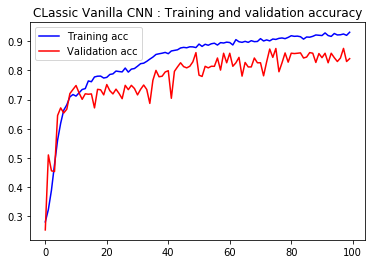

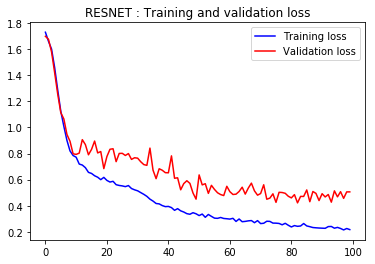

In [13]:
# Classic Model Accuracy
classic_acc = classic_training.history['acc']
classic_val_acc = classic_training.history['val_acc']
classic_loss = classic_training.history['loss']
classic_val_loss = classic_training.history['val_loss']
 
epochs = range(len(classic_acc))
 
plt.plot(epochs, classic_acc, 'b', label='Training acc')
plt.plot(epochs, classic_val_acc, 'r', label='Validation acc')
plt.title('CLassic Vanilla CNN : Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, classic_loss, 'b', label='Training loss')
plt.plot(epochs, classic_val_loss, 'r', label='Validation loss')
plt.title('RESNET : Training and validation loss')
plt.legend()
 
plt.show()

In [15]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)
 
# Get the filenames from the generator
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
predictions = classic_model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

Found 64 images belonging to 6 classes.
7/6 [================================] - 0s 11ms/step
No of errors = 10/64


## Hence proved that the classic vanilla modelis not suitable for such dataset . The best fit is the VGG16 Architecture .